# Lab 1: Implementing FEM for 1D Diffusion Equation

We implement the finite elements method (FEM) 
with piecewise linear ($\mathcal{P}_1$) basis functions to solve the 
one-dimensional diffusion equation:
$$ \text{(D):} \qquad \left\{ \begin{array}{cc}
    -(D(x) u'(x))' = f(x) & \text{ for } x\in (a,b) \\[0.5em]
    u(0) = u(1) = 0
\end{array} \right.\,.$$
In the equation $\text{(D)}$, $f: [a,b] \to \mathbf{R}$ is the *forcing* or *source* function,
$D: [a,b] \to \mathbf{R}$ is the diffusion (typically constant, in which case the equation reads $-Du'' = f$), and we search for 
a suitable $u: [a,b] \to \mathbf{R}$ in the *trial* space 
$$ \mathcal{V}([a,b]) = \{ v: [a,b] \to \mathbf{R} : v \in C^0([a,b]),\, v' \text{ is piecewise continuous and bounded on }[a,b]\}$$
The constraints $u(0) = u(1) = 0$ are so-called *Dirichlet* boundary conditions.

### Importing the code

Please refer to [https://github.com/labounad/comp-diffeq/blob/main/oneD/oneD_galerkin.py](https://github.com/labounad/comp-diffeq/blob/main/oneD/oneD_galerkin.py) for the full source code. 

This notebook is compatible with the ```lab1 report``` commit on 25/03/2025.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fem.fem1d import *

## Theory

The idea is to discretize the interval $[a,b]$ into pieces (elements) of 
width $h$, and approximate $u$ by a sequence $u_h$
converging to $u$, where each $u_h$ lives in the finite-dimensional space $\mathcal{V}_h = \text{span}\{\phi_0, \dots, \phi_n\}$.
The basis functions $\phi_i$ are chosen to be a piecewise linear partition of unity, such that, with $x_j,\, j=[0:n]$ denoting the $j$-th node, $\phi_i(x_j) = \delta_{ij}$. Explicitly:
$$ \phi_i(x) = \left\{ 
    \begin{array}{cl}
        \frac{x - x_{i-1}}{x_i - x_{i-1}}& x\in [x_{i-1}, x_i] \\[0.5em]
        \frac{x_{i+1} - x}{x_{i+1} - x_i} & x\in [x_i, x_{i+1}] \\[0.5em]
        0 & \text{else}
    \end{array}
\right.$$

An example with $n=8$ is depicted below:

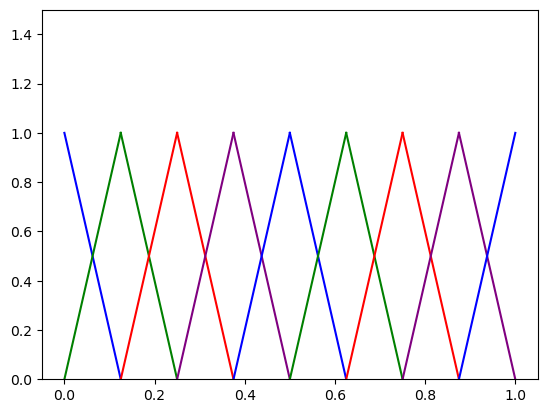

In [3]:
# plot basis functions:
n_elems = 8
nodes = n_elems + 1
x_start = TestParams.X_START
x_end = TestParams.X_END

x_coords = np.linspace(x_start, x_end, nodes)
colors = cycle(['blue', 'green', 'red', 'purple'])
for n in range(nodes):
    col = next(colors)
    if n > 0:
        plt.plot([x_coords[n-1], x_coords[n]], [0,1], color=col)
    if n < n_elems:
        plt.plot([x_coords[n], x_coords[n+1]], [1,0], color=col)
plt.ylim((0,1.5))
plt.show()

Then, one solves the *weak* formulation in $\mathcal{V}_h$: Find $u_h \in \mathcal{V}_h$ such that
$$ \mathrm{(W_h)}: \qquad (u_h', v') = (f, v) \quad \text{for all } v\in \mathcal{V}_h. $$
Since $u_h \in \mathcal{V}_h$ we have $u_h = \sum_j u_j \phi_j$ and since $v\in \mathcal{V}_h$ must be arbitrary, we must at least have $\mathrm{(W_h)}$ hold for the $\phi_j$, hence for all $j$: 
$$ (u_h', \phi_j') = \left( \sum_i u_i \phi_i', \phi_j' \right) = \sum_i u_i (\phi_i', \phi_j') = (f, \phi_j). $$
By defining $\mathbf{A} :=: \{a_{ij}\} := \{(\phi_i', \phi_j')\}$ and $\mathbf{b} :=: \{b_j\} := \{(f, \phi_j)\}$, 
we must solve $\mathbf{A u} = \mathbf{b}$. Such a solution $\mathbf{u} = \{u_i\}$ will then by linearity solve $\mathrm{(W_h)}$ for all $v \in \mathcal{V}_h$. 

The matrix $\mathbf{A}$ is called the *stiffness* matrix and the vector $\mathbf{b}$ the *load* vector.

## Implementation

To demonstrate the implementation, we take $[a,b] = [0,1]$, constant diffusion $D = 1$, 
and pick a test function $u_\text{real}(x) = \sin(k\pi x)$ and source $f(x) = -u_\text{real}''(x) = (k\pi)^2 \sin(k\pi x)$, with $k=15$, so that $u_\text{real}$ is a solution of $\mathrm{(D)}$.

We then approximate $u_\text{real}$ by functions $u_h$, where $h = n^{-1}$ for $n = 2^2, 2^3, \dots, 2^{12}$.

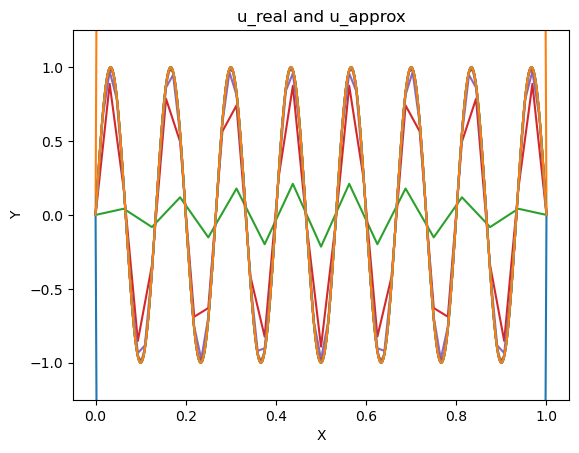

In [4]:
TestParams.K_CONST = 15

def constant_diffusion(x):
    return np.ones(len(x))

TestParams.diffusion_function = constant_diffusion

n_elems = [2**i for i in range(2, 13)]
x_start = 0
x_end = 1

residuals = []

for n_elem in n_elems:
    x_coords, u_approx, u_real = galerkin(n_elem, x_start, x_end)
    plt.plot(x_coords, u_approx)

    residuals.append(calc_l2err(x_coords, u_approx, u_real))

x_fine = np.linspace(x_start, x_end, 10 ** 4)
plt.plot(x_fine, TestParams.u_real(x_fine))
plt.ylim((-1.25, 1.25))

plt.xlabel("X")
plt.ylabel("Y")
plt.title("u_real and u_approx")
plt.show()

Here we have used $k = 13$, leading to instability for very small values of $n$, however, convergence is achieved. 

In the following test, we let $k = 4$ and $D(x)$ be the step function 
$$ D(x) = \left\{
    \begin{array}{rl}
        1 & x \in [0,0.5) \\
        2 & x\in [0.5, 1]
    \end{array}
\right.\,. $$

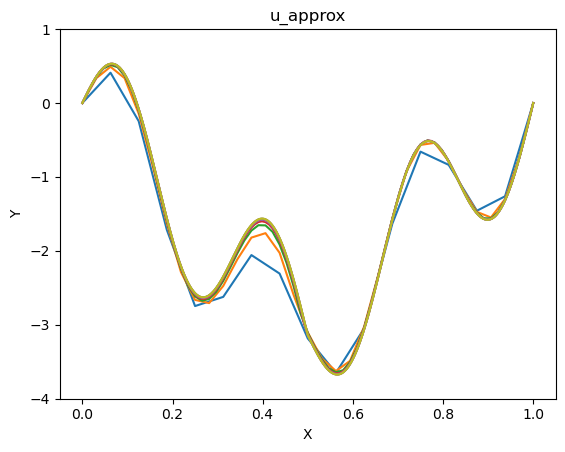

In [5]:
def step_diffusion(x):
    half_nodes = len(x) // 2
    other_half = len(x) - half_nodes
    return np.concatenate((np.ones(half_nodes), 2 * np.ones(other_half)))

TestParams.K_CONST = 6
TestParams.diffusion_function = step_diffusion

n_elems = [2**i for i in range(4, 13)]

for n_elem in n_elems:
    x_coords, u_approx, u_real = galerkin(n_elem, x_start, x_end)
    plt.plot(x_coords, u_approx)

x_fine = np.linspace(x_start, x_end, 10 ** 4)
plt.ylim((-4, 1))

plt.xlabel("X")
plt.ylabel("Y")
plt.title("u_approx")
plt.show()

## Convergence Analysis

In the first implementation above ($k=15$ and $D=1$), we calculated the residuals at each iteration.

Theory (Nietsche-Aubin) states that the residual error is $O(h^2)$:
$$ |\!| u_\text{real} - u_h |\!|_{L^2} \le h^2 |\!| u'' |\!|.$$
Thus if $h$ is halved every time, the ratio of residuals $e_{i} / e_{i+1}$ should tend to $4$.
Indeed, as the following plots demonstrate, this is precisely what is obtained:

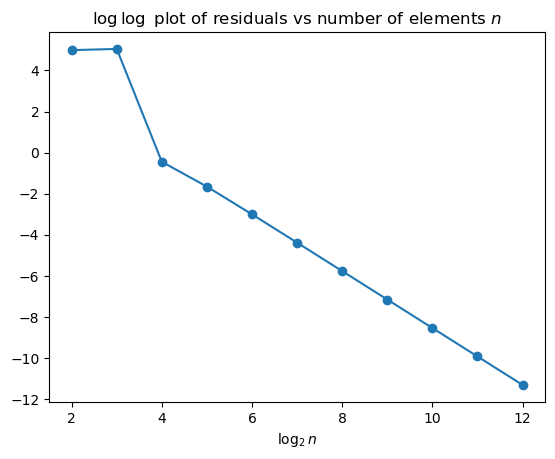

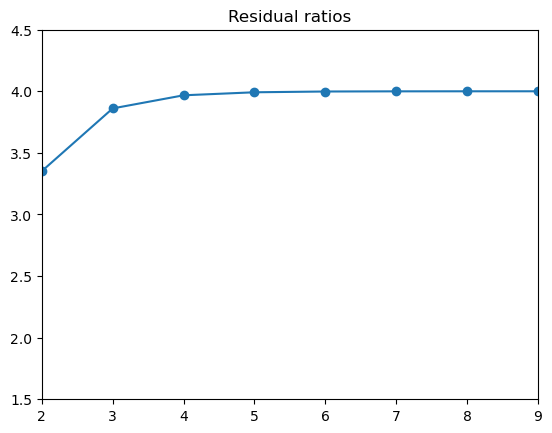

[  0.94221285 243.76541632   3.35197837   3.86095986   3.96735263
   3.99185585   3.99816691   3.99950123   3.99987523   3.99996899]


In [7]:
residuals = np.array(residuals)
plt.plot(range(2,13), np.log(residuals), marker='o')
plt.title('$\log \log$ plot of residuals vs number of elements $n$')
plt.xlabel('$\log_2 n$')
plt.show()

ratios = np.divide(residuals[:-1], residuals[1:])
plt.plot(ratios, marker='o')
plt.title("Residual ratios")
plt.xlim((2,9))
plt.ylim((1.5,4.5))
plt.show()

print(ratios)